In [236]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
import librosa
from librosa.core import resample, to_mono
from python_speech_features import mfcc, logfbank
from tqdm import tqdm
import os

preprocessing mainly used this tutorial: https://github.com/seth814/Audio-Classification

In [237]:
path = 'freesound-audio-tagging/'

data_train =pd.read_csv(path+'/training_new.csv')
data_test =pd.read_csv(path+'/testing_new.csv')
print(data_train,'\n',data_test)

            fname    label  manually_verified
0    002d256b.wav  Trumpet                  0
1    034e4ffa.wav  Trumpet                  0
2    03e13ae7.wav  Trumpet                  0
3    04335030.wav  Trumpet                  0
4    04490642.wav  Trumpet                  0
..            ...      ...                ...
505  147f4395.wav    Cello                  0
506  14fd19da.wav    Cello                  0
507  154df401.wav    Cello                  1
508  161be325.wav    Cello                  0
509  188acf6a.wav    Cello                  1

[510 rows x 3 columns] 
            fname             label  manually_verified
0   16d7ab94.wav           Trumpet                  1
1   17cbf99c.wav           Trumpet                  0
2   180cd1d7.wav           Trumpet                  1
3   1902bf23.wav           Trumpet                  0
4   1a13793b.wav           Trumpet                  0
5   20b47b1d.wav             Flute                  0
6   213274fa.wav             Flute          

In [238]:
#create a column with the audio length
df = data_train.set_index('fname')
print(df)
for f in df.index:
    rate, signal = wavfile.read(path+'audio_train/'+f)
    df.at[f,'length'] = signal.shape[0]/rate

#associste each class with the mean audio length of its entries
classes = list(np.unique(data_train.label))
classes_dist = df.groupby(['label'])['length'].mean()

print(df,'\n',classes_dist)

                label  manually_verified
fname                                   
002d256b.wav  Trumpet                  0
034e4ffa.wav  Trumpet                  0
03e13ae7.wav  Trumpet                  0
04335030.wav  Trumpet                  0
04490642.wav  Trumpet                  0
...               ...                ...
147f4395.wav    Cello                  0
14fd19da.wav    Cello                  0
154df401.wav    Cello                  1
161be325.wav    Cello                  0
188acf6a.wav    Cello                  1

[510 rows x 2 columns]
                label  manually_verified  length
fname                                           
002d256b.wav  Trumpet                  0    0.44
034e4ffa.wav  Trumpet                  0    3.70
03e13ae7.wav  Trumpet                  0    8.64
04335030.wav  Trumpet                  0    1.08
04490642.wav  Trumpet                  0   23.60
...               ...                ...     ...
147f4395.wav    Cello                  0    5.22
14

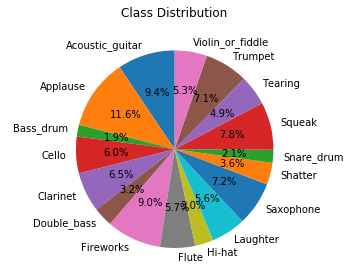

In [239]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(classes_dist, labels = classes_dist.index, autopct = '%1.1f%%',shadow=False, startangle = 90)
ax.axis('equal')
plt.show()


In [240]:
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y  = abs(np.fft.rfft(y)/n)
    return (Y,freq)

def plot_signals(signals):
    fig, axes = plt.subplots(nrows=3,ncols=5,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Time Series',size=16)
    i=0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=3,ncols=5,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Fourier Transforms',size=16)
    i=0
    for x in range(3):
        for y in range(5):
            data = list(fft.values())[i]
            Y , freq = data[0],data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq,Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_fbanks(fbank):
    fig, axes = plt.subplots(nrows=3,ncols=5,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Filter Bank Coefficient',size=16)
    i=0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=3,ncols=5,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients',size=16)
    i=0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
#to remove ts dying ends           
def envelope(y, rate, threshold):
    mask =[]
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),
                       min_periods=1,
                       center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


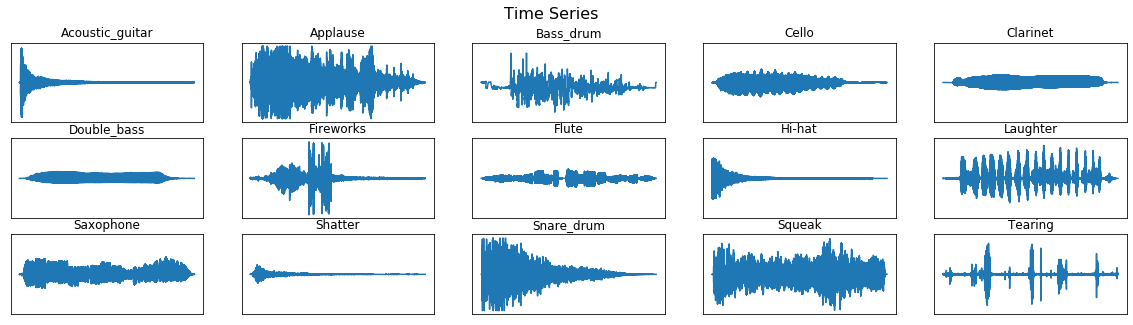

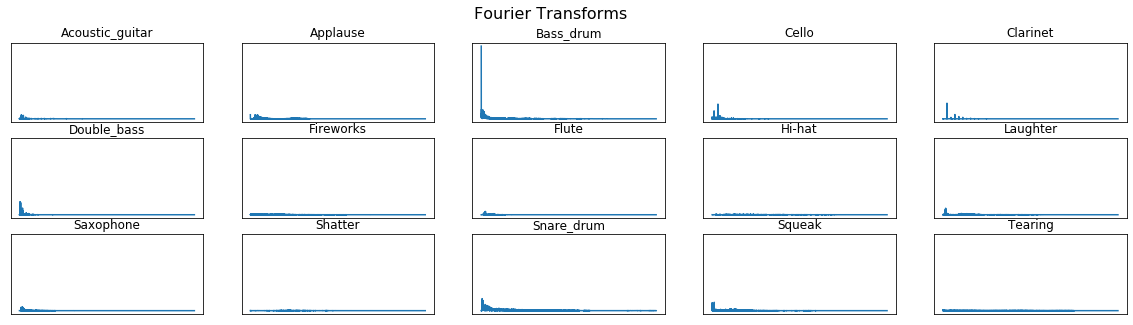

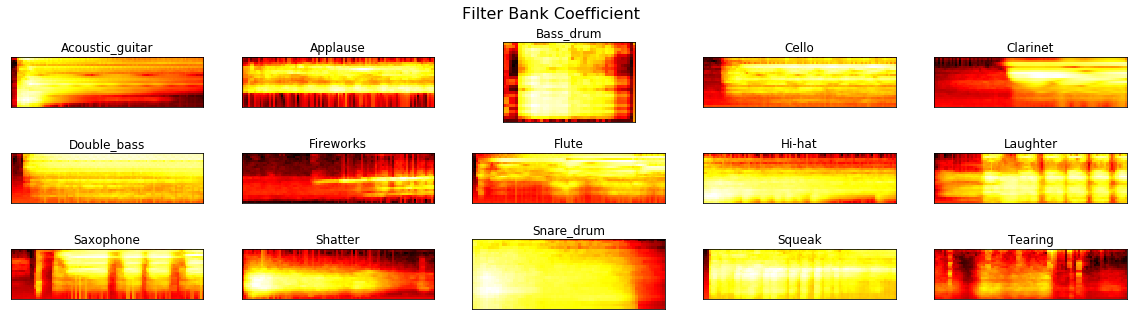

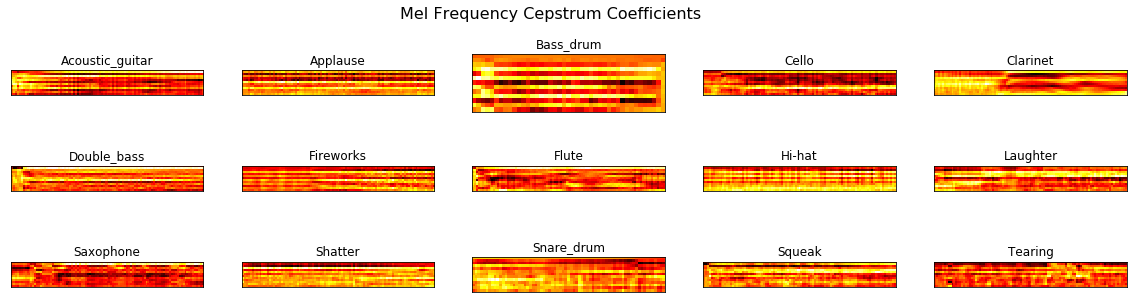

In [241]:
#visualize samples from each category
signals = {}
fft = {}
fbank = {}
mfccs = {}
for c in classes:
    wav_file = data_train[data_train.label ==  c].iloc[0,0]
    signal, rate = librosa.load(path+'audio_train/'+wav_file, sr=44100)
    mask = envelope(signal, rate,0.0005)
    signal = signal[mask]
    signals[c]=signal
    fft[c] = calc_fft(signal,rate)
    bank = logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1103).T
    mfccs[c]=mel
     
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbanks(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [242]:
# save cleaned files (downsampled to 16000 sampling rate,apply envelope)
if len(os.listdir(path+'clean')) == 0:
    for f in tqdm(data_train.fname):
        signal , rate= librosa.load(path+'/audio_train/'+f,sr=16000)
        mask = envelope(signal,rate,0.0005)
        wavfile.write(filename=path+'clean/'+f,rate=rate,data=signal[mask])